# Notebook lecture 12: Model Predictive Control
&copy; 2025 ETH Zurich, Ivan Robuschi, William Schnyder, Niclas Scheuer, Dejan Milojevic; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

Authors:
- Ivan Robuschi; irobuschi@ethz.ch
- William Schnyder; wschnyder@ethz.ch

In [ ]:
!pip install cvxpy ecos control matplotlib

---

## Exericse 1 - From LQR to MPC


### 1. System Description and State-Space Matrices

We consider a continuous-time linearized model of an aircraft at altitude of 5000m and a speed of 128.2 m/sec:

$$
\dot x = A\,x + B\,u, \quad y = C\,x + D\,u,
$$

with states:
- $x_1$: angle of attack,
- $x_2$: pitch angle,
- $x_3$: pitch rate,
- $x_4$: altitude,

and control input $u$: elevator angle.

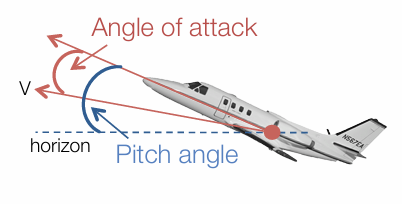

State-space representation:

$$
A = \begin{bmatrix}
-1.2822 & 0      & 0.98    & 0      \\
0       & 0      & 1.00    & 0      \\
-5.4293 & 0      & -1.8366 & 0      \\
-128.2  & 128.2  & 0       & 0
\end{bmatrix},
\quad
B = \begin{bmatrix}-0.3 \\ 0 \\ -17 \\ 0\end{bmatrix},
$$

$$
C = \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}, \quad
D = \begin{bmatrix} 0 \\ 0 \end{bmatrix},
\quad T_s = 0.25~\mathrm{s}.
$$

There are some constraints that need to be satisfied:

- Elevator angle: $\pm0.262$ rad, ($\pm15^\circ$)  
- Elevator rate: $\pm0.524$ rad/s, ($\pm33^\circ$/s)  
- Pitch angle: $\pm0.349$ rad, ($\pm39^\circ$)

Run the cells below to setup the problem.

In [10]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import control

# System setup
A = np.array([[-1.2822,     0,      0.98,       0],
              [0,           0,      1,          0],
              [-5.4293,     0,      -1.8366,    0],
              [-128.2,      128.2,  0,          0]])
B = np.array([[-0.3], [0], [-17], [0]])
C = np.array([[0, 1, 0, 0], [0, 0, 0, 1]])
D = np.zeros((2,1))

# Discretize system
Ts = 0.25
sys_c = control.ss(A, B, C, D)
sys_d = control.c2d(sys_c, Ts)
Ad, Bd = sys_d.A, sys_d.B

# Constraints (MPC)
u_max = 0.262
# u_rate_max = 0.349 * Ts
# x2_max = 0.349
u_rate_max = 0.524 * Ts
x2_max = 0.524

# Additional parameters
T_sim = int(10 / Ts)
nx, nu = Ad.shape[0], Bd.shape[1]

# Prepare scenarios (different I.C. and horizons)
x0 = np.array([0, 0, 0, 10])
x0_high = np.array([0, 0, 0, 100])
N_def, N_small = 10, 3

# Plotting function for scenarios
def plot_scenario(ax_state, ax_input, title, run):
    x, u = run()

    fig = ax_state.figure
    fig.suptitle(title, fontsize=16, y=0.98)

    # Time vectors
    t  = np.arange(T_sim+1) * Ts
    tu = np.arange(len(u)) * Ts

    # State plot
    ax1 = ax_state
    ax1.plot(t, x[:, 3], 'b', label='x4')
    ax1.set_ylabel('Altitude [m]', color='b')
    ax1.tick_params(labelcolor='b')
    ax1.grid(True)

    ax1r = ax1.twinx()
    ax1r.plot(t, x[:, 1], 'g', label='x2')
    ax1r.set_ylabel('Pitch angle [rad]', color='g')
    ax1r.tick_params(labelcolor='g')
    ax1r.axhline( x2_max,  color='g', linestyle='--')
    ax1r.axhline(-x2_max,  color='g', linestyle='--')

    # Combine legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax1r.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc='upper right')
    ax1.set_title("State Plot")

    # Control input plot
    ax2 = ax_input
    ax2.step(tu, u.flatten(), where='post', color='b', label='u')
    ax2.axhline( u_max,  color='r', linestyle='--')
    ax2.axhline(-u_max,  color='r', linestyle='--')
    ax2.set_ylabel('Elevator angle [rad]', color='b')
    ax2.set_xlabel('t [s]')
    ax2.set_ylim(-0.5, 0.5)
    ax2.grid(True)
    ax2.legend(loc='upper right')
    ax2.set_title("Control Input Plot")

### 2. LQR vs. MPC: Formulations and Motivation
#### 2.1 LQR Formulation

We solve the infinite-horizon optimal control problem:

$$
\begin{aligned}
    J_\infty^*(x(k))
    &=\;\min\sum_{k=0}^\infty \bigl(x_k^T Q x_k + u_k^T R u_k\bigr) \\
    \text{subject to}\quad
    &\begin{cases}
    x_{k+1} = Ax_k + Bu_k,\\
    x_0 = x(k).
    \end{cases}
\end{aligned}
$$

with state-weighting $Q$ and input-weighting $R$.  
The resulting state feedback law is

$$
u_k = K_{LQR}x_k,
$$

where $K_{LQR}$ and the cost-to-go $P_\infty$ satisfy the discrete Algebraic Riccati Equation.

Run the cell below to setup the LQR formulation.

In [2]:
# Weights for LQR
Q = np.eye(nx)
R = 10 * np.eye(nu)

# Compute LQR gain and P_inf matrix
K_lqr, P_inf, _ = control.dlqr(Ad, Bd, Q, R)

# LQR with saturation
def simulate_lqr(x0, K, T, u_max, saturate):
    # Initialize state and input arrays
    x = np.zeros((nx, T+1))
    u = np.zeros((nu, T))

    # initial condition
    x[:, 0] = x0

    for k in range(T):

        # Compute control input, saturate (yes/no), and propagate dynamics
        u_unsat = -K @ x[:, k]

        if saturate:
            u_temp = np.clip(u_unsat, -u_max, u_max) # input saturation
            if k > 0:
                delta_u = u_temp - u[:, k-1] # input rate saturation
                delta_u_sat = np.clip(delta_u, -u_rate_max, u_rate_max)
                u_temp = u[:, k-1] + delta_u_sat
        else:
            u_temp = u_unsat

        u[:, k] = u_temp
        x[:, k+1] = Ad @ x[:, k] + Bd @ u[:, k]

    return x.T, u.T

The standard LQR formulation does not allow explicit handling of input or state constraints. As a result, applying actuator saturations e.g. clipping $u_k$ can violate the optimality and stability guarantees of the Riccati solution.

Run the cell below to observe how LQR control with a saturated controller can lead to instability.

In [ ]:
# Run and plot scenario 1 (LQR without input saturation)
run_lqr = lambda: simulate_lqr(x0, K_lqr, T_sim, u_max, saturate=False)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
plot_scenario(ax_state=axes[0], ax_input=axes[1], title="LQR without input saturation", run=run_lqr)
plt.tight_layout()
plt.show()

# Run and plot scenario 2 (LQR with input saturation)
run_lqr_sat = lambda: simulate_lqr(x0, K_lqr, T_sim, u_max, saturate=True)
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
plot_scenario(ax_state=axes[0], ax_input=axes[1], title="LQR with input saturation", run=run_lqr_sat)
plt.tight_layout()
plt.show()

#### 2.2 MPC Formulation

Model Predictive Control (MPC) overcomes LQR’s inability to enforce hard constraints by solving a finite‐horizon optimal control problem online in a receding‐horizon fashion.  At each time step $k$:

1. Measure or estimate the current state $x_k$,
2. Find the optimal input sequence for the entire planning window $N$,
3. Apply only the first control input $u_0^\star$.

Formally, given the current state $x(k)$, MPC solves

$$
\begin{aligned}
    J^*(x(k))
    &=\;\min_{u}
      \sum_{k=0}^{N-1} \bigl(x_k^T Q x_k + u_k^T R u_k\bigr)
      + x_N^T P_f x_N, \\[6pt]
    \text{subject to}\quad
    &\begin{cases}
      x_{k+1} = Ax_k + Bu_k, & k = 0,\dots,N-1,\\
      x_k \in X, u_k \in U,\\
      x_N \in X_N,\\
      x_0 = x(k).
    \end{cases}
\end{aligned}
$$

Run the cell below to setup the MPC formulation.

In [11]:
# MPC optimization problem
def solve_mpc(x0, N, constr_u, constr_x, constr_xT):

    # Decision variables
    x = cp.Variable((nx, N+1))
    u = cp.Variable((nu, N))

    # Initialize cost and constraints
    cost = 0
    constraints = []

    # Define intial state constraint
    constraints += [x[:, 0] == x0]

    for k in range(N):

        # Cost function (objective)
        cost += cp.quad_form(x[:, k], Q) + cp.quad_form(u[:, k], R)
        # Dynamics constraints
        constraints += [x[:, k+1] == Ad @ x[:, k] + Bd @ u[:, k]]
        # Input constraints
        if constr_u:
            constraints += [cp.abs(u[:, k]) <= u_max]
            constraints += [cp.abs(u[:, k] - u[:, k-1]) <= u_rate_max]
        # State constraints
        if constr_x:
            constraints += [cp.abs(x[1, k]) <= x2_max] if x2_max is not None else []

    # Terminal cost and constraints
    if constr_xT:
        cost += cp.quad_form(x[:, N], P_inf)
        constraints += [ cp.abs(K_lqr @ x[:, N]) <= u_max]
        constraints += [ cp.abs(x[1 ,N]) <= x2_max]


    # Define problem and solve
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve(solver=cp.ECOS, verbose=False)
    return u[:, 0].value.flatten()

# Simulate MPC over T_sim an plot trajectories
def simulate_mpc(title, x0, N, constr_u=False, constr_x=False, constr_xT=False):
    # Initialize state and input trajectories
    x = np.zeros((nx, T_sim+1))
    u = np.zeros((nu, T_sim))
    x[:, 0] = x0

    for k in range(T_sim):

        # Solve MPC problem, get first control input and propagate system
        u[:, k] = solve_mpc(x[:, k], N, constr_u, constr_x, constr_xT)
        x[:, k+1] = Ad @ x[:, k] + Bd @ u[:, k]

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    plot_scenario(ax_state=axes[0], ax_input=axes[1], title=title, run=lambda: (x.T, u.T))
    plt.tight_layout()
    plt.show()

In the following sections we will explore, step by step, how the constraints and design choice affect the closed‐loop behaviour of the MPC. Let's start with the input constraints.

**MPC without constraints**

- In the so called unconstrained MPC, there are no input constraints and no state constraints. The controller still drives both altitude and pitch to their set-points and keeps the pitch-angle bound satisfied, even without constraints. Yet the elevator angle and rate exceed their physical limits.

**MPC with all input constraints**

- After activating the given hard bounds on the elevator and its rate, the controller continues to achieve convergence while this time respecting all input limits.

Run the cell below to visualize those two scenarios.

In [ ]:
# Run and plot scenario 2 (MPC without constraints)
simulate_mpc("MPC without constraints", x0=x0, N=N_def)

# Run and plot scenario 3 (MPC with all input constraints)
simulate_mpc("MPC with all input constraints", x0=x0, N=N_def, constr_u=True)

Let's move on and change the initial condition to a deviation of 100m of the desired altitude and see what happens.

**MPC with larger initial condition**

- Starting from an altitude deviation of 100m, the controller again drives both altitude and pitch to their targets. The more aggressive descent however forces the pitch angle to go lower than the acceptable limit specified in the task. The plot shows that it even goes below -0.8 rad which is approximately -45°.

**MPC with state constraints**

- By adding a hard bound on the pitch, we can see on the plot, that the constraint indeed gets activated, not allowing the pitch angle to go below/above a certain limit.

Run the cell below to visualize those two scenarios.

In [ ]:
# Run and plot scenario 4 (larger the initial condition)
simulate_mpc("MPC with larger initial condition", x0=x0_high, N=N_def, constr_u=True)

# Run and plot scenario 5 (MPC with state constraints)
simulate_mpc("MPC with state constraints", x0=x0_high, N=N_def, constr_u=True, constr_x=True)

In these final two scenarios, we first shrink the prediction horizon to observe its effects, and then show the standard way how to solve the arised issue, ending with the complete formulation for the standard MPC.  

**MPC with short horizon**  
- Shrinking the horizon makes the controller short-sighted, meaning it optimizes only the near future and can overlook longer-term consequences. This decrease in the prediction horizon can lead to loss of stability properties, so the closed-loop may oscillate or even drift away. 

**Note:** Our earlier examples remained stable only because we chose a sufficiently long horizon which kept the deviation between the open-loop prediction and the closed-loop system small. Try yourself and shrink the horizon length $N_{def}$ and make the controller “short-sighted,” such that it optimizes only over the near future and potentially neglects long-term effects, leading to a loss of stability.

**MPC with terminal cost and constraint**  
- Rather than re-analysing stability each time parameters change, we append a terminal cost and terminal constraint which approximate the infinite-horizon tail that we truncated when going from the infinite-horizon LQR formulation to this finite-horizon MPC one. And just like that, stability guarantees are restored.

In [ ]:
# Run and plot scenario 6 (shrinking the horizon)
simulate_mpc("MPC with short horizon", x0=x0, N=N_small, constr_u=True, constr_x=True)

# Run and plot scenario 7 (adding terminal cost and constraint)
simulate_mpc("MPC with terminal cost and constraint", x0=x0, N=N_small, constr_u=True, constr_x=True, constr_xT=True)

## Exercise 2 - Constrained convex optimization

As learnt in the lecture, Model Predictive Control runs online optimization to find the optimal control input at every time step. For this sake, we define a cost function associated to the controller's actions and look for the control input minimizing this cost.

This exercise aims to visualize a few concepts related to optimization. Here, we focus on optimizing a convex cost function in a simple, univariate case.

### Convexity

First of all, it is necessary for us to understand what a convex function is. By "convex function" we mean a function whereby the line segment connecting two distinct points on the function is always above the function itself. Intuitively, a convex function can be imagined as "bowl-shaped".

Run the cell below and try moving the sliders: it can be seen that the function given below is convex.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider
from IPython.display import display

# Define a more irregular-but-convex function
def f(x):
    # soft-plus gives a smooth kink, x^4 adds bumps, log term tames growth
    return np.log1p(np.exp(0.5 * x)) + 0.02 * x**4

def plot_convex(x1, x2):
    x = np.linspace(-5, 5, 500)
    y = f(x)
    y1, y2 = f(x1), f(x2)

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, label='f(x)', linewidth=2)
    plt.scatter([x1, x2], [y1, y2], color='red', s=50)
    plt.plot([x1, x2], [y1, y2], '--', linewidth=2, label='Chord')

    plt.title('Convexity visualization')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.ylim(min(y) - 0.5, max(y) + 0.5)
    plt.grid(True)
    plt.legend()
    plt.show()

interactive_plot = interactive(
    plot_convex,
    x1=FloatSlider(value=-2, min=-5, max=5, step=0.1, description='x₁'),
    x2=FloatSlider(value= 2, min=-5, max=5, step=0.1, description='x₂')
)

display(interactive_plot)


In MPC and in general, it is very convenient to define a convex cost function: finding the minimum numerically is far easier than with non-convex functions.

Remember: In this simple example, our objective is to quickly and easily find the parameter x that minimizes the cost (since the optimization runs at every time step, computation time is very limited).


In real systems, we may want to impose constraints on the optimization to prevent the controller from relying on unfeasible control input or even reaching dangerous areas.

One way to implement constraints is to modify the original cost function by adding to it so-called barriers, which are terms that make the cost:
- Approach infinity as we get closer to the constraints;
- Undefined outside of the constraints.

Mathematically, the total cost, composed of original cost and $m$ barriers, is of the following form:

$$J_{tot}=f_0(x)-\frac{1}{t}\sum_{i=1}^{m}log(-f_i(x)).$$

The usage of barriers as constraints can be visualized by running the cell below. Particularly important is the parameter $t$: As you can see by moving the slider in the below cell, it defines "how steep" the barriers get.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, FloatLogSlider
from IPython.display import display

# Base convex function
def original_cost(x):
    return np.log1p(np.exp(0.5 * x)) + 0.02 * x**4

def plot_with_barrier_and_minima(x1, x2, t):
    color_orig = "green"
    color_barrier = "red"

    x = np.linspace(-5, 5, 1000)
    y_orig = original_cost(x)

    # Normalize slacks so they lie in (0,1)
    W = x2 - x1
    s1 = (x - x1) / W
    s2 = (x2 - x) / W

    # Compute barrier term
    barrier = np.full_like(x, np.nan)
    feasible = (x > x1) & (x < x2)
    barrier[feasible] = - (1 / t) * (np.log(s1[feasible]) + np.log(s2[feasible]))

    y_barrier = y_orig + barrier

    # Find minima in feasible region
    x_feas = x[feasible]
    orig_feas = y_orig[feasible]
    barr_feas = y_barrier[feasible]

    idx_min_orig = np.argmin(orig_feas)
    idx_min_barr = np.argmin(barr_feas)

    x_min_orig = x_feas[idx_min_orig]
    y_min_orig = orig_feas[idx_min_orig]
    x_min_barr = x_feas[idx_min_barr]
    y_min_barr = barr_feas[idx_min_barr]

    plt.figure(figsize=(8, 5))
    # Plot original and barrier-augmented costs
    plt.plot(x, y_orig, label='Original cost', color=color_orig, linewidth=2)
    plt.plot(x, y_barrier, label='Cost with constraints', color=color_barrier, linewidth=2)
    # Constraint lines
    plt.axvline(x=x1, linestyle='--', color=color_barrier, linewidth=2, label='Constraints')
    plt.axvline(x=x2, linestyle='--', color=color_barrier, linewidth=2)
    # Plot minima
    plt.scatter([x_min_orig], [y_min_orig], color=color_orig, s=50, zorder=5, label='Min feasible cost')
    plt.scatter([x_min_barr], [y_min_barr], color=color_barrier, edgecolor='black', s=50, zorder=5, label='Min total cost')

    plt.xlim(-5, 5)
    plt.ylim(0, 5)

    plt.title('Original vs. constrained Cost')
    plt.xlabel('x')
    plt.ylabel('Cost value')
    plt.grid(True)
    plt.legend()
    plt.show()

# Interactive sliders: x1, x2 and log-scaled t
interactive_plot = interactive(
    plot_with_barrier_and_minima,
    x1=FloatSlider(value=-2, min=-5, max=-0.1, step=0.1, description='x₁'),
    x2=FloatSlider(value=2, min=0, max=5, step=0.1, description='x₂'),
    t=FloatLogSlider(value=10, base=10, min=-0.3, max=2, step=0.01, description='t')
)

display(interactive_plot)


As you can see, choosing a high value of $t$ makes the total cost closer to the original cost. Therefore, at first glance, one might think to choose $t$ as big as possible, so that the minimum we find (red point in the plot) is closer to the actual feasible minimum (green dot).

However, increasing $t$ also makes the barriers steeper. For numerical reasons, very big gradients can be problematic for optimization methods like gradient descent. Therefore, we need a strategy to help us get as near as possible to the true feasible minimum while only running optimization in areas with moderate gradients.

One such strategy consists in the so-called barrier point method. You can run the cell below to visualize the process (the sliders allow you to tweak the constraints).  Optimization is initialized at a point where gradients do not explode and for a low value of $t$, which allows to quickly find a first estimate of the minimum. Then, iteratively, $t$ is increased and a new optimization is done starting from the optimal $x$ found in the previous iteration. These iterations with progressively higher $t$ are repeated until convergence.

This strategy makes it possible to find minima quickly and arbitrarily well, while avoiding areas with exploding gradients.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider
from IPython.display import display

# Base convex function
def f0(x):
    return np.log1p(np.exp(0.5 * x)) + 0.02 * x**4

# Total cost with normalized log-barrier
def total_cost(x, x1, x2, t):
    y0 = f0(x)
    W = x2 - x1
    s1 = (x - x1) / W
    s2 = (x2 - x) / W
    barrier = np.full_like(x, np.nan)
    feasible = (x > x1) & (x < x2)
    barrier[feasible] = - (1 / t) * (np.log(s1[feasible]) + np.log(s2[feasible]))
    return y0 + barrier

def plot_iterative_barrier(x1, x2):
    x = np.linspace(-5, 5, 1000)
    t_values = [1, 10, 100]
    x_mins_total = []

    # Compute unconstrained feasible minimum once
    y0 = f0(x)
    feasible = (x > x1) & (x < x2)
    x_feas = x[feasible]
    y0_feas = y0[feasible]
    idx_min_f0 = np.argmin(y0_feas)
    x_min_f0 = x_feas[idx_min_f0]
    y_min_f0 = y0_feas[idx_min_f0]

    # Compute minima for each t sequentially
    for t in t_values:
        total = total_cost(x, x1, x2, t)
        total_feas = total[feasible]
        idx_min = np.argmin(total_feas)
        x_mins_total.append(x_feas[idx_min])

    # Starting point in the middle
    x_start = 0.5 * (x1 + x2)
    y_start = total_cost(np.array([x_start]), x1, x2, t_values[0])[0]

    # New color scheme
    color_base = "#6a0dad"        # Purple for f₀(x)
    color_total = "#008080"       # Teal for total cost
    color_constraints = "#b5651d" # Brown for constraints
    color_feas = "#ff69b4"        # Pink for min feasible f₀
    color_prev = "#7f8c8d"        # Gray for previous total minima
    color_curr = "#000000"        # Black for current total minima
    color_start = "#1f77b4"       # Gold for start point

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
    for i, (ax, t, x_min_tot) in enumerate(zip(axes, t_values, x_mins_total)):
        total = total_cost(x, x1, x2, t)

        # Plot cost curves
        ax.plot(x, y0, label='Cost without constraints', color=color_base, linewidth=2)
        ax.plot(x, total, label='Cost with constraints', color=color_total, linewidth=2)

        # Constraint lines
        ax.axvline(x=x1, linestyle='--', color=color_constraints, linewidth=2)
        ax.axvline(x=x2, linestyle='--', color=color_constraints, linewidth=2)

        # Plot starting point only in first subplot
        if i == 0:
            ax.scatter([x_start], [y_start], color=color_start, edgecolor='black',
                       s=80, zorder=5, label='Start (mid-interval)')
            ax.plot([x_start, x_start], [0, y_start], linestyle='--', color=color_start, linewidth=1)

        # Min feasible f₀
        ax.scatter([x_min_f0], [y_min_f0], color=color_feas, edgecolor='black',
                   s=80, zorder=5, label='Min feasible cost')
        ax.plot([x_min_f0, x_min_f0], [0, y_min_f0], linestyle='--', color=color_feas, linewidth=1)

        # Previous total minima
        if i > 0:
            x_prev = x_mins_total[i-1]
            y_prev = total_cost(np.array([x_prev]), x1, x2, t)[0]
            ax.scatter([x_prev], [y_prev], color=color_prev, edgecolor='white',
                       s=80, zorder=5, label='Previous minimum found')
            ax.plot([x_prev, x_prev], [0, y_prev], linestyle='--', color=color_prev, linewidth=1)

        # Current total minima
        y_curr = total_cost(np.array([x_min_tot]), x1, x2, t)[0]
        ax.scatter([x_min_tot], [y_curr], color=color_curr, edgecolor='white',
                   s=80, zorder=5, label='Current minimum found')
        ax.plot([x_min_tot, x_min_tot], [0, y_curr], linestyle='--', color=color_curr, linewidth=1)

        # Axis settings
        ax.set_xlim(-5, 5)
        ax.set_ylim(0, 5)
        ax.set_title(f'Iteration {i+1}: t={t}')
        ax.set_xlabel('x')
        ax.grid(True)

    axes[0].set_ylabel('Cost')

    # Create a single legend below the plots
    handles = [
        plt.Line2D([0], [0], color=color_base, lw=2, label='Cost without constraints'),
        plt.Line2D([0], [0], color=color_total, lw=2, label='Cost with constraints'),
        plt.Line2D([0], [0], linestyle='--', color=color_constraints, lw=2, label='Constraints'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_start,
                   markeredgecolor='black', markersize=10, label='Start (mid-interval)'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_feas,
                   markeredgecolor='black', markersize=10, label='Min feasible cost'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_prev,
                   markeredgecolor='white', markersize=10, label='Previous minimum found'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_curr,
                   markeredgecolor='white', markersize=10, label='Current minimum found')
    ]
    fig.legend(handles=handles, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.05))

    plt.suptitle('Iterative optimization progressively increasing t')
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

# Interactive sliders for constraints
interactive_plot = interactive(
    plot_iterative_barrier,
    x1=FloatSlider(value=-2, min=-5, max=-0.1, step=0.1, description='x₁'),
    x2=FloatSlider(value=2, min=0, max=5, step=0.1, description='x₂')
)

display(interactive_plot)
